# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.661886 -0.825008  1.0  0.077834  1.718164 -0.222980  0  0  18.127546   
1  1.131393 -0.156150  1.0  0.803707  0.072027  0.071285  2  1  28.387419   
2  0.768518  0.631459  1.0  0.793720  1.268985 -1.917109  2  3  33.974695   
3  1.493622 -0.168389  1.0  0.688450  0.590800 -0.337449  2  1  26.631797   
4  1.988792  1.654148  1.0  0.883690  0.765500 -1.815631  1  3  34.456986   

            y  
0  133.202799  
1  347.640747  
2  535.106674  
3  347.913448  
4  815.075783  
True causal estimate is 14.71165540148336


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

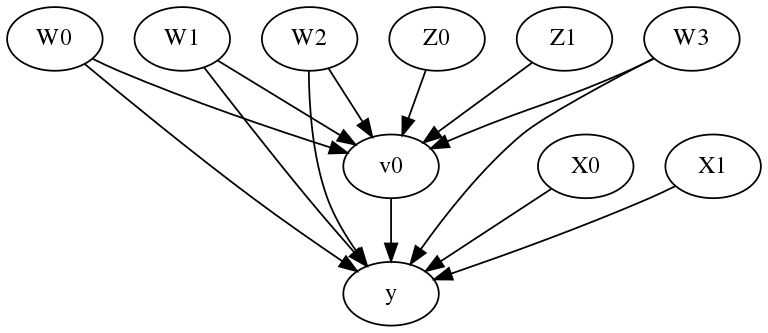

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W0,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W0,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 14.711319173121122
### Conditional Estimates
__categorical__X1  __categorical__X0            
(-3.284, -0.261]   (-2.8939999999999997, -0.121]     4.092962
                   (-0.121, 0.465]                   6.231216
                   (0.465, 0.953]                    7.664354
                   (0.953, 1.553]                    8.359392
                   (1.553, 4.431]                   10.512789
(-0.261, 0.35]     (-2.8939999999999997, -0.121]     8.738985
                   (-0.121, 0.465]                  10.786103
                   (0

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-06-30 22:14:54.499748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 22:14:54.500167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W0,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 16.934487662765527
Effect estimates: [11.45062752 12.22508087 23.42988549 ... 17.74611332 25.39831898
 13.97625524]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 14.71165540148336


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W0,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: 

## Estimate
Mean value: 14.649421145245304
Effect estimates: [ 6.81149796 11.60996917 14.99298711 ... 13.30471681 25.67277299
 14.08320312]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W0,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 14.66096651041755
Effect estimates: [ 6.57374872 11.4379225  15.00479196 ... 13.55999037 25.62592318
 14.0096844 ]
95.0% confidence interval: (array([ 6.0425134 , 11.26105317, 15.12058868, ..., 13.62253785,
       25.86107228, 14.02913972]), array([ 6.78492849, 11.71456979, 15.49262267, ..., 14.33610673,
       26.81881822, 14.37995888]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[14.49356609 16.4868799  12.18751725 11.98442116 13.81578104 13.22303443
 12.10557106 13.47541159 10.26845356 13.10149197]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.782981 -1.096387  1.0  0.282298 -0.466235 -0.219511  0.311821   
1    -0.830488 -1.545445  0.0  0.276348 -0.752954 -0.024779 -0.600316   
2    -0.540664 -0.523615  1.0  0.424689 -2.077253 -0.900734  0.249907   
3     0.487102  0.390842  0.0  0.523225  0.213066  1.216592  1.548362   
4    -0.723386 -0.656942  1.0  0.349620 -0.973853 -1.529683  1.290594   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.625457  0.381333  1.0  0.724520  0.502370  0.006416 -1.145946   
9996 -0.573121 -1.581239  1.0  0.567507 -2.187703 -0.430952 -0.907068   
9997  1.080551 -1.292595  0.0  0.843275 -0.567974 -1.621397 -1.398838   
9998 -1.982115 -1.953494  0.0  0.735061 -2.101366 -2.081522 -1.024817   
9999 -0.787741  0.387441  1.0  0.423428 -1.469472  0.730507 -2.379538   

            W3  v0  y  
0     2.214181   1  0  
1    -0.323886   0  0  
2     0.479321   1  1  
3     1.441237   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W0,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.36820197927565423
Effect estimates: [ 0.12143546  0.19581887  0.37463375 ...  0.50061301 -0.02232526
  0.46246037]

True causal estimate is 0.2913


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-06-30 22:16:47.826065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 22:16:47.826502: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 22:16:47.826842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AMSHAR-Z840): /proc/driver/nvidia/version does not exist
2022-06-30 22:16:47.827535: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:57 - loss: 226.7816

 12/313 [>.............................] - ETA: 1s - loss: 114.7160  

 25/313 [=>............................] - ETA: 1s - loss: 66.4146 

 42/313 [===>..........................] - ETA: 1s - loss: 42.8277

 60/313 [====>.........................] - ETA: 0s - loss: 31.6417

 78/313 [======>.......................] - ETA: 0s - loss: 25.5575

 95/313 [========>.....................] - ETA: 0s - loss: 21.8767

114/313 [=========>....................] - ETA: 0s - loss: 19.0659

133/313 [===========>..................] - ETA: 0s - loss: 17.0483

152/313 [=============>................] - ETA: 0s - loss: 15.5410

170/313 [===============>..............] - ETA: 0s - loss: 14.3905

189/313 [=================>............] - ETA: 0s - loss: 13.4199

207/313 [==================>...........] - ETA: 0s - loss: 12.6605

226/313 [====================>.........] - ETA: 0s - loss: 11.9872

245/313 [======================>.......] - ETA: 0s - loss: 11.4013

263/313 [========================>.....] - ETA: 0s - loss: 10.9238

282/313 [==========================>...] - ETA: 0s - loss: 10.4896

301/313 [===========================>..] - ETA: 0s - loss: 10.1003

313/313 [==============================] - 2s 3ms/step - loss: 9.8750


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 4.7137

 20/313 [>.............................] - ETA: 0s - loss: 4.3303

 39/313 [==>...........................] - ETA: 0s - loss: 4.2866

 59/313 [====>.........................] - ETA: 0s - loss: 4.2800

 78/313 [======>.......................] - ETA: 0s - loss: 4.2526

 97/313 [========>.....................] - ETA: 0s - loss: 4.2433

116/313 [==========>...................] - ETA: 0s - loss: 4.2271

135/313 [===========>..................] - ETA: 0s - loss: 4.2142

154/313 [=============>................] - ETA: 0s - loss: 4.2035

173/313 [===============>..............] - ETA: 0s - loss: 4.1935

192/313 [=================>............] - ETA: 0s - loss: 4.1762

211/313 [===================>..........] - ETA: 0s - loss: 4.1650

230/313 [=====================>........] - ETA: 0s - loss: 4.1562

249/313 [======================>.......] - ETA: 0s - loss: 4.1477

268/313 [========================>.....] - ETA: 0s - loss: 4.1395

287/313 [==========================>...] - ETA: 0s - loss: 4.1313

306/313 [============================>.] - ETA: 0s - loss: 4.1227

313/313 [==============================] - 1s 3ms/step - loss: 4.1188


Epoch 3/25
  1/313 [..............................] - ETA: 1s - loss: 3.9449

 20/313 [>.............................] - ETA: 0s - loss: 3.9101

 39/313 [==>...........................] - ETA: 0s - loss: 3.9085

 57/313 [====>.........................] - ETA: 0s - loss: 3.9013

 76/313 [======>.......................] - ETA: 0s - loss: 3.8448

 94/313 [========>.....................] - ETA: 0s - loss: 3.8115

113/313 [=========>....................] - ETA: 0s - loss: 3.7385

132/313 [===========>..................] - ETA: 0s - loss: 3.6704

152/313 [=============>................] - ETA: 0s - loss: 3.6115

171/313 [===============>..............] - ETA: 0s - loss: 3.5566

190/313 [=================>............] - ETA: 0s - loss: 3.5064

209/313 [===================>..........] - ETA: 0s - loss: 3.4681

228/313 [====================>.........] - ETA: 0s - loss: 3.4310

247/313 [======================>.......] - ETA: 0s - loss: 3.4033

266/313 [========================>.....] - ETA: 0s - loss: 3.3804

285/313 [==========================>...] - ETA: 0s - loss: 3.3520

304/313 [============================>.] - ETA: 0s - loss: 3.3323

313/313 [==============================] - 1s 3ms/step - loss: 3.3227


Epoch 4/25
  1/313 [..............................] - ETA: 0s - loss: 3.1429

 20/313 [>.............................] - ETA: 0s - loss: 3.0525

 39/313 [==>...........................] - ETA: 0s - loss: 3.0320

 58/313 [====>.........................] - ETA: 0s - loss: 3.0189

 77/313 [======>.......................] - ETA: 0s - loss: 3.0146

 97/313 [========>.....................] - ETA: 0s - loss: 3.0163

116/313 [==========>...................] - ETA: 0s - loss: 3.0048

135/313 [===========>..................] - ETA: 0s - loss: 2.9927

153/313 [=============>................] - ETA: 0s - loss: 2.9984

173/313 [===============>..............] - ETA: 0s - loss: 3.0015

191/313 [=================>............] - ETA: 0s - loss: 2.9956

210/313 [===================>..........] - ETA: 0s - loss: 2.9891

229/313 [====================>.........] - ETA: 0s - loss: 2.9886

248/313 [======================>.......] - ETA: 0s - loss: 2.9840

267/313 [========================>.....] - ETA: 0s - loss: 2.9824

286/313 [==========================>...] - ETA: 0s - loss: 2.9778

305/313 [============================>.] - ETA: 0s - loss: 2.9740

313/313 [==============================] - 1s 3ms/step - loss: 2.9703


Epoch 5/25
  1/313 [..............................] - ETA: 1s - loss: 3.0389

 20/313 [>.............................] - ETA: 0s - loss: 2.9559

 39/313 [==>...........................] - ETA: 0s - loss: 2.9648

 58/313 [====>.........................] - ETA: 0s - loss: 2.9669

 77/313 [======>.......................] - ETA: 0s - loss: 2.9688

 95/313 [========>.....................] - ETA: 0s - loss: 2.9541

113/313 [=========>....................] - ETA: 0s - loss: 2.9451

133/313 [===========>..................] - ETA: 0s - loss: 2.9436

152/313 [=============>................] - ETA: 0s - loss: 2.9360

171/313 [===============>..............] - ETA: 0s - loss: 2.9339

190/313 [=================>............] - ETA: 0s - loss: 2.9331

209/313 [===================>..........] - ETA: 0s - loss: 2.9359

228/313 [====================>.........] - ETA: 0s - loss: 2.9332

247/313 [======================>.......] - ETA: 0s - loss: 2.9273

266/313 [========================>.....] - ETA: 0s - loss: 2.9312

285/313 [==========================>...] - ETA: 0s - loss: 2.9326

304/313 [============================>.] - ETA: 0s - loss: 2.9329

313/313 [==============================] - 1s 3ms/step - loss: 2.9308


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 3.2652

 20/313 [>.............................] - ETA: 0s - loss: 2.8760

 40/313 [==>...........................] - ETA: 0s - loss: 2.9022

 59/313 [====>.........................] - ETA: 0s - loss: 2.8927

 79/313 [======>.......................] - ETA: 0s - loss: 2.9020

 98/313 [========>.....................] - ETA: 0s - loss: 2.9166

117/313 [==========>...................] - ETA: 0s - loss: 2.9183

136/313 [============>.................] - ETA: 0s - loss: 2.9323

155/313 [=============>................] - ETA: 0s - loss: 2.9346

174/313 [===============>..............] - ETA: 0s - loss: 2.9316

193/313 [=================>............] - ETA: 0s - loss: 2.9221

212/313 [===================>..........] - ETA: 0s - loss: 2.9188

231/313 [=====================>........] - ETA: 0s - loss: 2.9118

250/313 [======================>.......] - ETA: 0s - loss: 2.9087

269/313 [========================>.....] - ETA: 0s - loss: 2.9090

288/313 [==========================>...] - ETA: 0s - loss: 2.9068

307/313 [============================>.] - ETA: 0s - loss: 2.9051

313/313 [==============================] - 1s 3ms/step - loss: 2.9057


Epoch 7/25
  1/313 [..............................] - ETA: 0s - loss: 2.8413

 20/313 [>.............................] - ETA: 0s - loss: 2.8676

 39/313 [==>...........................] - ETA: 0s - loss: 2.8758

 57/313 [====>.........................] - ETA: 0s - loss: 2.8869

 76/313 [======>.......................] - ETA: 0s - loss: 2.8758

 95/313 [========>.....................] - ETA: 0s - loss: 2.8795

113/313 [=========>....................] - ETA: 0s - loss: 2.8850

132/313 [===========>..................] - ETA: 0s - loss: 2.8855

150/313 [=============>................] - ETA: 0s - loss: 2.8850

169/313 [===============>..............] - ETA: 0s - loss: 2.8892

188/313 [=================>............] - ETA: 0s - loss: 2.8948

208/313 [==================>...........] - ETA: 0s - loss: 2.8898

227/313 [====================>.........] - ETA: 0s - loss: 2.8921

246/313 [======================>.......] - ETA: 0s - loss: 2.8906

265/313 [========================>.....] - ETA: 0s - loss: 2.8879

284/313 [==========================>...] - ETA: 0s - loss: 2.8857

303/313 [============================>.] - ETA: 0s - loss: 2.8897

313/313 [==============================] - 1s 3ms/step - loss: 2.8900


Epoch 8/25
  1/313 [..............................] - ETA: 1s - loss: 2.9597

 20/313 [>.............................] - ETA: 0s - loss: 2.8170

 39/313 [==>...........................] - ETA: 0s - loss: 2.8446

 58/313 [====>.........................] - ETA: 0s - loss: 2.8549

 77/313 [======>.......................] - ETA: 0s - loss: 2.8794

 95/313 [========>.....................] - ETA: 0s - loss: 2.8857

113/313 [=========>....................] - ETA: 0s - loss: 2.8828

133/313 [===========>..................] - ETA: 0s - loss: 2.8798

152/313 [=============>................] - ETA: 0s - loss: 2.8738

171/313 [===============>..............] - ETA: 0s - loss: 2.8700

190/313 [=================>............] - ETA: 0s - loss: 2.8771

209/313 [===================>..........] - ETA: 0s - loss: 2.8790

228/313 [====================>.........] - ETA: 0s - loss: 2.8809

247/313 [======================>.......] - ETA: 0s - loss: 2.8821

266/313 [========================>.....] - ETA: 0s - loss: 2.8769

285/313 [==========================>...] - ETA: 0s - loss: 2.8756

304/313 [============================>.] - ETA: 0s - loss: 2.8711

313/313 [==============================] - 1s 3ms/step - loss: 2.8702


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 2.8596

 20/313 [>.............................] - ETA: 0s - loss: 2.9279

 39/313 [==>...........................] - ETA: 0s - loss: 2.9312

 58/313 [====>.........................] - ETA: 0s - loss: 2.9366

 77/313 [======>.......................] - ETA: 0s - loss: 2.9108

 96/313 [========>.....................] - ETA: 0s - loss: 2.9154

115/313 [==========>...................] - ETA: 0s - loss: 2.9042

134/313 [===========>..................] - ETA: 0s - loss: 2.8986

152/313 [=============>................] - ETA: 0s - loss: 2.8956

171/313 [===============>..............] - ETA: 0s - loss: 2.8964

190/313 [=================>............] - ETA: 0s - loss: 2.8891

209/313 [===================>..........] - ETA: 0s - loss: 2.8895

228/313 [====================>.........] - ETA: 0s - loss: 2.8870

247/313 [======================>.......] - ETA: 0s - loss: 2.8815

266/313 [========================>.....] - ETA: 0s - loss: 2.8844

285/313 [==========================>...] - ETA: 0s - loss: 2.8819

304/313 [============================>.] - ETA: 0s - loss: 2.8790

313/313 [==============================] - 1s 3ms/step - loss: 2.8793


Epoch 10/25
  1/313 [..............................] - ETA: 0s - loss: 2.6960

 20/313 [>.............................] - ETA: 0s - loss: 2.8838

 39/313 [==>...........................] - ETA: 0s - loss: 2.8550

 57/313 [====>.........................] - ETA: 0s - loss: 2.8495

 76/313 [======>.......................] - ETA: 0s - loss: 2.8476

 95/313 [========>.....................] - ETA: 0s - loss: 2.8391

114/313 [=========>....................] - ETA: 0s - loss: 2.8402

133/313 [===========>..................] - ETA: 0s - loss: 2.8444

152/313 [=============>................] - ETA: 0s - loss: 2.8507

171/313 [===============>..............] - ETA: 0s - loss: 2.8527

190/313 [=================>............] - ETA: 0s - loss: 2.8524

209/313 [===================>..........] - ETA: 0s - loss: 2.8550

228/313 [====================>.........] - ETA: 0s - loss: 2.8556

247/313 [======================>.......] - ETA: 0s - loss: 2.8555

266/313 [========================>.....] - ETA: 0s - loss: 2.8585

285/313 [==========================>...] - ETA: 0s - loss: 2.8602

304/313 [============================>.] - ETA: 0s - loss: 2.8584

313/313 [==============================] - 1s 3ms/step - loss: 2.8568


Epoch 11/25
  1/313 [..............................] - ETA: 1s - loss: 2.8935

 20/313 [>.............................] - ETA: 0s - loss: 2.8291

 39/313 [==>...........................] - ETA: 0s - loss: 2.8551

 58/313 [====>.........................] - ETA: 0s - loss: 2.8567

 77/313 [======>.......................] - ETA: 0s - loss: 2.8548

 96/313 [========>.....................] - ETA: 0s - loss: 2.8592

115/313 [==========>...................] - ETA: 0s - loss: 2.8555

133/313 [===========>..................] - ETA: 0s - loss: 2.8492

152/313 [=============>................] - ETA: 0s - loss: 2.8533

171/313 [===============>..............] - ETA: 0s - loss: 2.8503

190/313 [=================>............] - ETA: 0s - loss: 2.8525

209/313 [===================>..........] - ETA: 0s - loss: 2.8480

228/313 [====================>.........] - ETA: 0s - loss: 2.8501

247/313 [======================>.......] - ETA: 0s - loss: 2.8532

265/313 [========================>.....] - ETA: 0s - loss: 2.8532

284/313 [==========================>...] - ETA: 0s - loss: 2.8501

303/313 [============================>.] - ETA: 0s - loss: 2.8494

313/313 [==============================] - 1s 3ms/step - loss: 2.8503


Epoch 12/25
  1/313 [..............................] - ETA: 1s - loss: 2.9291

 20/313 [>.............................] - ETA: 0s - loss: 2.8445

 39/313 [==>...........................] - ETA: 0s - loss: 2.8507

 57/313 [====>.........................] - ETA: 0s - loss: 2.8478

 76/313 [======>.......................] - ETA: 0s - loss: 2.8418

 95/313 [========>.....................] - ETA: 0s - loss: 2.8390

114/313 [=========>....................] - ETA: 0s - loss: 2.8340

133/313 [===========>..................] - ETA: 0s - loss: 2.8281

152/313 [=============>................] - ETA: 0s - loss: 2.8310

171/313 [===============>..............] - ETA: 0s - loss: 2.8320

190/313 [=================>............] - ETA: 0s - loss: 2.8260

209/313 [===================>..........] - ETA: 0s - loss: 2.8297

228/313 [====================>.........] - ETA: 0s - loss: 2.8317

247/313 [======================>.......] - ETA: 0s - loss: 2.8345

266/313 [========================>.....] - ETA: 0s - loss: 2.8365

285/313 [==========================>...] - ETA: 0s - loss: 2.8394

304/313 [============================>.] - ETA: 0s - loss: 2.8401

313/313 [==============================] - 1s 3ms/step - loss: 2.8392


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 2.9484

 19/313 [>.............................] - ETA: 0s - loss: 2.7996

 38/313 [==>...........................] - ETA: 0s - loss: 2.8176

 57/313 [====>.........................] - ETA: 0s - loss: 2.8291

 76/313 [======>.......................] - ETA: 0s - loss: 2.8352

 95/313 [========>.....................] - ETA: 0s - loss: 2.8407

114/313 [=========>....................] - ETA: 0s - loss: 2.8428

133/313 [===========>..................] - ETA: 0s - loss: 2.8386

152/313 [=============>................] - ETA: 0s - loss: 2.8360

171/313 [===============>..............] - ETA: 0s - loss: 2.8354

191/313 [=================>............] - ETA: 0s - loss: 2.8292

210/313 [===================>..........] - ETA: 0s - loss: 2.8302

229/313 [====================>.........] - ETA: 0s - loss: 2.8287

248/313 [======================>.......] - ETA: 0s - loss: 2.8278

267/313 [========================>.....] - ETA: 0s - loss: 2.8315

286/313 [==========================>...] - ETA: 0s - loss: 2.8319

305/313 [============================>.] - ETA: 0s - loss: 2.8340

313/313 [==============================] - 1s 3ms/step - loss: 2.8363


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 2.6790

 20/313 [>.............................] - ETA: 0s - loss: 2.8273

 39/313 [==>...........................] - ETA: 0s - loss: 2.8258

 58/313 [====>.........................] - ETA: 0s - loss: 2.8352

 77/313 [======>.......................] - ETA: 0s - loss: 2.8302

 96/313 [========>.....................] - ETA: 0s - loss: 2.8315

115/313 [==========>...................] - ETA: 0s - loss: 2.8387

134/313 [===========>..................] - ETA: 0s - loss: 2.8332

153/313 [=============>................] - ETA: 0s - loss: 2.8293

172/313 [===============>..............] - ETA: 0s - loss: 2.8284

192/313 [=================>............] - ETA: 0s - loss: 2.8274

211/313 [===================>..........] - ETA: 0s - loss: 2.8320

231/313 [=====================>........] - ETA: 0s - loss: 2.8328

250/313 [======================>.......] - ETA: 0s - loss: 2.8316

269/313 [========================>.....] - ETA: 0s - loss: 2.8312

289/313 [==========================>...] - ETA: 0s - loss: 2.8309

309/313 [============================>.] - ETA: 0s - loss: 2.8295

313/313 [==============================] - 1s 3ms/step - loss: 2.8287


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 2.6691

 20/313 [>.............................] - ETA: 0s - loss: 2.8326

 39/313 [==>...........................] - ETA: 0s - loss: 2.8229

 58/313 [====>.........................] - ETA: 0s - loss: 2.8109

 77/313 [======>.......................] - ETA: 0s - loss: 2.8238

 96/313 [========>.....................] - ETA: 0s - loss: 2.8205

115/313 [==========>...................] - ETA: 0s - loss: 2.8132

134/313 [===========>..................] - ETA: 0s - loss: 2.8125

153/313 [=============>................] - ETA: 0s - loss: 2.8211

172/313 [===============>..............] - ETA: 0s - loss: 2.8224

191/313 [=================>............] - ETA: 0s - loss: 2.8162

210/313 [===================>..........] - ETA: 0s - loss: 2.8216

229/313 [====================>.........] - ETA: 0s - loss: 2.8241

248/313 [======================>.......] - ETA: 0s - loss: 2.8211

267/313 [========================>.....] - ETA: 0s - loss: 2.8224

286/313 [==========================>...] - ETA: 0s - loss: 2.8185

306/313 [============================>.] - ETA: 0s - loss: 2.8183

313/313 [==============================] - 1s 3ms/step - loss: 2.8174


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 2.8411

 20/313 [>.............................] - ETA: 0s - loss: 2.8407

 39/313 [==>...........................] - ETA: 0s - loss: 2.8177

 58/313 [====>.........................] - ETA: 0s - loss: 2.8121

 77/313 [======>.......................] - ETA: 0s - loss: 2.8147

 95/313 [========>.....................] - ETA: 0s - loss: 2.8129

114/313 [=========>....................] - ETA: 0s - loss: 2.8104

133/313 [===========>..................] - ETA: 0s - loss: 2.8068

152/313 [=============>................] - ETA: 0s - loss: 2.8060

171/313 [===============>..............] - ETA: 0s - loss: 2.8099

191/313 [=================>............] - ETA: 0s - loss: 2.8056

210/313 [===================>..........] - ETA: 0s - loss: 2.8122

230/313 [=====================>........] - ETA: 0s - loss: 2.8106

250/313 [======================>.......] - ETA: 0s - loss: 2.8128

270/313 [========================>.....] - ETA: 0s - loss: 2.8132

289/313 [==========================>...] - ETA: 0s - loss: 2.8125

308/313 [============================>.] - ETA: 0s - loss: 2.8144

313/313 [==============================] - 1s 3ms/step - loss: 2.8160


Epoch 17/25
  1/313 [..............................] - ETA: 0s - loss: 2.8286

 21/313 [=>............................] - ETA: 0s - loss: 2.7602

 40/313 [==>...........................] - ETA: 0s - loss: 2.7697

 59/313 [====>.........................] - ETA: 0s - loss: 2.7725

 78/313 [======>.......................] - ETA: 0s - loss: 2.7843

 98/313 [========>.....................] - ETA: 0s - loss: 2.7932

118/313 [==========>...................] - ETA: 0s - loss: 2.7994

138/313 [============>.................] - ETA: 0s - loss: 2.7993

158/313 [==============>...............] - ETA: 0s - loss: 2.8036

177/313 [===============>..............] - ETA: 0s - loss: 2.8034

197/313 [=================>............] - ETA: 0s - loss: 2.8040

217/313 [===================>..........] - ETA: 0s - loss: 2.8076

236/313 [=====================>........] - ETA: 0s - loss: 2.8097

255/313 [=======================>......] - ETA: 0s - loss: 2.8122

274/313 [=========================>....] - ETA: 0s - loss: 2.8107

293/313 [===========================>..] - ETA: 0s - loss: 2.8061

312/313 [============================>.] - ETA: 0s - loss: 2.8082

313/313 [==============================] - 1s 3ms/step - loss: 2.8094


Epoch 18/25
  1/313 [..............................] - ETA: 0s - loss: 2.6212

 21/313 [=>............................] - ETA: 0s - loss: 2.8339

 41/313 [==>...........................] - ETA: 0s - loss: 2.8332

 60/313 [====>.........................] - ETA: 0s - loss: 2.8179

 80/313 [======>.......................] - ETA: 0s - loss: 2.8099

 99/313 [========>.....................] - ETA: 0s - loss: 2.8110

118/313 [==========>...................] - ETA: 0s - loss: 2.8065

137/313 [============>.................] - ETA: 0s - loss: 2.8020

156/313 [=============>................] - ETA: 0s - loss: 2.8025

175/313 [===============>..............] - ETA: 0s - loss: 2.8025

195/313 [=================>............] - ETA: 0s - loss: 2.8011

214/313 [===================>..........] - ETA: 0s - loss: 2.8026

233/313 [=====================>........] - ETA: 0s - loss: 2.8037

252/313 [=======================>......] - ETA: 0s - loss: 2.8032

271/313 [========================>.....] - ETA: 0s - loss: 2.8036

291/313 [==========================>...] - ETA: 0s - loss: 2.8010

310/313 [============================>.] - ETA: 0s - loss: 2.8021

313/313 [==============================] - 1s 3ms/step - loss: 2.8009


Epoch 19/25
  1/313 [..............................] - ETA: 1s - loss: 2.7470

 21/313 [=>............................] - ETA: 0s - loss: 2.7785

 41/313 [==>...........................] - ETA: 0s - loss: 2.7958

 60/313 [====>.........................] - ETA: 0s - loss: 2.7874

 79/313 [======>.......................] - ETA: 0s - loss: 2.7842

 98/313 [========>.....................] - ETA: 0s - loss: 2.7880

117/313 [==========>...................] - ETA: 0s - loss: 2.7933

137/313 [============>.................] - ETA: 0s - loss: 2.7964

156/313 [=============>................] - ETA: 0s - loss: 2.7968

175/313 [===============>..............] - ETA: 0s - loss: 2.7895

194/313 [=================>............] - ETA: 0s - loss: 2.7888

213/313 [===================>..........] - ETA: 0s - loss: 2.7874

232/313 [=====================>........] - ETA: 0s - loss: 2.7905

251/313 [=======================>......] - ETA: 0s - loss: 2.7896

270/313 [========================>.....] - ETA: 0s - loss: 2.7911

289/313 [==========================>...] - ETA: 0s - loss: 2.7954

308/313 [============================>.] - ETA: 0s - loss: 2.7970

313/313 [==============================] - 1s 3ms/step - loss: 2.7976


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 2.8024

 20/313 [>.............................] - ETA: 0s - loss: 2.8031

 39/313 [==>...........................] - ETA: 0s - loss: 2.7708

 58/313 [====>.........................] - ETA: 0s - loss: 2.7722

 78/313 [======>.......................] - ETA: 0s - loss: 2.7788

 98/313 [========>.....................] - ETA: 0s - loss: 2.7871

117/313 [==========>...................] - ETA: 0s - loss: 2.7932

136/313 [============>.................] - ETA: 0s - loss: 2.7893

156/313 [=============>................] - ETA: 0s - loss: 2.7891

175/313 [===============>..............] - ETA: 0s - loss: 2.7876

195/313 [=================>............] - ETA: 0s - loss: 2.7870

215/313 [===================>..........] - ETA: 0s - loss: 2.7873

234/313 [=====================>........] - ETA: 0s - loss: 2.7875

253/313 [=======================>......] - ETA: 0s - loss: 2.7874

273/313 [=========================>....] - ETA: 0s - loss: 2.7922

293/313 [===========================>..] - ETA: 0s - loss: 2.7923

312/313 [============================>.] - ETA: 0s - loss: 2.7919

313/313 [==============================] - 1s 3ms/step - loss: 2.7918


Epoch 21/25
  1/313 [..............................] - ETA: 0s - loss: 2.6515

 21/313 [=>............................] - ETA: 0s - loss: 2.7863

 40/313 [==>...........................] - ETA: 0s - loss: 2.7927

 59/313 [====>.........................] - ETA: 0s - loss: 2.7832

 78/313 [======>.......................] - ETA: 0s - loss: 2.7875

 97/313 [========>.....................] - ETA: 0s - loss: 2.7847

117/313 [==========>...................] - ETA: 0s - loss: 2.7797

136/313 [============>.................] - ETA: 0s - loss: 2.7817

155/313 [=============>................] - ETA: 0s - loss: 2.7832

175/313 [===============>..............] - ETA: 0s - loss: 2.7833

195/313 [=================>............] - ETA: 0s - loss: 2.7862

214/313 [===================>..........] - ETA: 0s - loss: 2.7824

234/313 [=====================>........] - ETA: 0s - loss: 2.7841

255/313 [=======================>......] - ETA: 0s - loss: 2.7864

275/313 [=========================>....] - ETA: 0s - loss: 2.7925

295/313 [===========================>..] - ETA: 0s - loss: 2.7950

313/313 [==============================] - 1s 3ms/step - loss: 2.7929


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 2.7966

 20/313 [>.............................] - ETA: 0s - loss: 2.7942

 39/313 [==>...........................] - ETA: 0s - loss: 2.7967

 59/313 [====>.........................] - ETA: 0s - loss: 2.8093

 79/313 [======>.......................] - ETA: 0s - loss: 2.7982

 99/313 [========>.....................] - ETA: 0s - loss: 2.7943

118/313 [==========>...................] - ETA: 0s - loss: 2.7914

138/313 [============>.................] - ETA: 0s - loss: 2.7901

157/313 [==============>...............] - ETA: 0s - loss: 2.7905

177/313 [===============>..............] - ETA: 0s - loss: 2.7913

197/313 [=================>............] - ETA: 0s - loss: 2.7899

216/313 [===================>..........] - ETA: 0s - loss: 2.7893

236/313 [=====================>........] - ETA: 0s - loss: 2.7901

256/313 [=======================>......] - ETA: 0s - loss: 2.7908

275/313 [=========================>....] - ETA: 0s - loss: 2.7898

295/313 [===========================>..] - ETA: 0s - loss: 2.7905

313/313 [==============================] - 1s 3ms/step - loss: 2.7897


Epoch 23/25
  1/313 [..............................] - ETA: 1s - loss: 2.6997

 21/313 [=>............................] - ETA: 0s - loss: 2.7541

 40/313 [==>...........................] - ETA: 0s - loss: 2.7579

 59/313 [====>.........................] - ETA: 0s - loss: 2.7753

 78/313 [======>.......................] - ETA: 0s - loss: 2.7758

 97/313 [========>.....................] - ETA: 0s - loss: 2.7703

116/313 [==========>...................] - ETA: 0s - loss: 2.7776

135/313 [===========>..................] - ETA: 0s - loss: 2.7832

155/313 [=============>................] - ETA: 0s - loss: 2.7803

174/313 [===============>..............] - ETA: 0s - loss: 2.7826

194/313 [=================>............] - ETA: 0s - loss: 2.7808

213/313 [===================>..........] - ETA: 0s - loss: 2.7791

232/313 [=====================>........] - ETA: 0s - loss: 2.7810

251/313 [=======================>......] - ETA: 0s - loss: 2.7815

271/313 [========================>.....] - ETA: 0s - loss: 2.7815

290/313 [==========================>...] - ETA: 0s - loss: 2.7800

309/313 [============================>.] - ETA: 0s - loss: 2.7815

313/313 [==============================] - 1s 3ms/step - loss: 2.7833


Epoch 24/25
  1/313 [..............................] - ETA: 0s - loss: 2.7102

 21/313 [=>............................] - ETA: 0s - loss: 2.7388

 40/313 [==>...........................] - ETA: 0s - loss: 2.7614

 59/313 [====>.........................] - ETA: 0s - loss: 2.7718

 78/313 [======>.......................] - ETA: 0s - loss: 2.7731

 97/313 [========>.....................] - ETA: 0s - loss: 2.7739

116/313 [==========>...................] - ETA: 0s - loss: 2.7766

135/313 [===========>..................] - ETA: 0s - loss: 2.7794

153/313 [=============>................] - ETA: 0s - loss: 2.7784

173/313 [===============>..............] - ETA: 0s - loss: 2.7790

193/313 [=================>............] - ETA: 0s - loss: 2.7827

212/313 [===================>..........] - ETA: 0s - loss: 2.7829

231/313 [=====================>........] - ETA: 0s - loss: 2.7827

247/313 [======================>.......] - ETA: 0s - loss: 2.7841

268/313 [========================>.....] - ETA: 0s - loss: 2.7859

288/313 [==========================>...] - ETA: 0s - loss: 2.7816

308/313 [============================>.] - ETA: 0s - loss: 2.7872

313/313 [==============================] - 1s 3ms/step - loss: 2.7877


Epoch 25/25
  1/313 [..............................] - ETA: 1s - loss: 2.8213

 21/313 [=>............................] - ETA: 0s - loss: 2.8098

 40/313 [==>...........................] - ETA: 0s - loss: 2.7941

 60/313 [====>.........................] - ETA: 0s - loss: 2.7906

 80/313 [======>.......................] - ETA: 0s - loss: 2.7984

100/313 [========>.....................] - ETA: 0s - loss: 2.7899

120/313 [==========>...................] - ETA: 0s - loss: 2.7846

140/313 [============>.................] - ETA: 0s - loss: 2.7807

160/313 [==============>...............] - ETA: 0s - loss: 2.7854

180/313 [================>.............] - ETA: 0s - loss: 2.7863

200/313 [==================>...........] - ETA: 0s - loss: 2.7848

220/313 [====================>.........] - ETA: 0s - loss: 2.7815

240/313 [======================>.......] - ETA: 0s - loss: 2.7795

259/313 [=======================>......] - ETA: 0s - loss: 2.7789

278/313 [=========================>....] - ETA: 0s - loss: 2.7816

297/313 [===========================>..] - ETA: 0s - loss: 2.7803

313/313 [==============================] - 1s 3ms/step - loss: 2.7790


Epoch 1/25


  1/313 [..............................] - ETA: 4:20 - loss: 199372.5312

 10/313 [..............................] - ETA: 1s - loss: 205569.3125  

 19/313 [>.............................] - ETA: 1s - loss: 215162.8750

 28/313 [=>............................] - ETA: 1s - loss: 208301.2812

 39/313 [==>...........................] - ETA: 1s - loss: 196514.8438

 50/313 [===>..........................] - ETA: 1s - loss: 187880.7344

 62/313 [====>.........................] - ETA: 1s - loss: 174045.0000

 75/313 [======>.......................] - ETA: 1s - loss: 157207.8438

 88/313 [=======>......................] - ETA: 1s - loss: 142762.1250

100/313 [========>.....................] - ETA: 1s - loss: 132516.8594

112/313 [=========>....................] - ETA: 0s - loss: 125840.4297

125/313 [==========>...................] - ETA: 0s - loss: 119699.3047

139/313 [============>.................] - ETA: 0s - loss: 114786.7578

152/313 [=============>................] - ETA: 0s - loss: 109634.5625

166/313 [==============>...............] - ETA: 0s - loss: 104959.9766

180/313 [================>.............] - ETA: 0s - loss: 102269.5547

193/313 [=================>............] - ETA: 0s - loss: 99625.2344 

206/313 [==================>...........] - ETA: 0s - loss: 97258.1875

219/313 [===================>..........] - ETA: 0s - loss: 95161.2969

233/313 [=====================>........] - ETA: 0s - loss: 93107.0078

246/313 [======================>.......] - ETA: 0s - loss: 90793.8203

259/313 [=======================>......] - ETA: 0s - loss: 88617.5000

273/313 [=========================>....] - ETA: 0s - loss: 86477.2422

286/313 [==========================>...] - ETA: 0s - loss: 85138.1328

300/313 [===========================>..] - ETA: 0s - loss: 83131.2734

313/313 [==============================] - 2s 4ms/step - loss: 81640.6172


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 39796.2773

 15/313 [>.............................] - ETA: 1s - loss: 41151.9297

 29/313 [=>............................] - ETA: 1s - loss: 42252.9609

 43/313 [===>..........................] - ETA: 0s - loss: 42684.1406

 58/313 [====>.........................] - ETA: 0s - loss: 41463.0273

 72/313 [=====>........................] - ETA: 0s - loss: 40293.6328

 86/313 [=======>......................] - ETA: 0s - loss: 39115.2148

100/313 [========>.....................] - ETA: 0s - loss: 38424.8672

115/313 [==========>...................] - ETA: 0s - loss: 38038.6602

129/313 [===========>..................] - ETA: 0s - loss: 37297.0547

144/313 [============>.................] - ETA: 0s - loss: 36860.4961

158/313 [==============>...............] - ETA: 0s - loss: 36580.2344

172/313 [===============>..............] - ETA: 0s - loss: 35944.6992

187/313 [================>.............] - ETA: 0s - loss: 35610.4414

202/313 [==================>...........] - ETA: 0s - loss: 35027.8086

217/313 [===================>..........] - ETA: 0s - loss: 35039.6562

231/313 [=====================>........] - ETA: 0s - loss: 35190.6328

245/313 [======================>.......] - ETA: 0s - loss: 35061.4414

259/313 [=======================>......] - ETA: 0s - loss: 34798.9375

273/313 [=========================>....] - ETA: 0s - loss: 34614.0508

288/313 [==========================>...] - ETA: 0s - loss: 34483.7109

303/313 [============================>.] - ETA: 0s - loss: 34331.4805

313/313 [==============================] - 1s 4ms/step - loss: 34242.8906


Epoch 3/25
  1/313 [..............................] - ETA: 1s - loss: 27069.3906

 16/313 [>.............................] - ETA: 1s - loss: 30155.5781

 30/313 [=>............................] - ETA: 1s - loss: 32231.5273

 45/313 [===>..........................] - ETA: 0s - loss: 32283.5547

 59/313 [====>.........................] - ETA: 0s - loss: 31297.7031

 74/313 [======>.......................] - ETA: 0s - loss: 31539.9062

 89/313 [=======>......................] - ETA: 0s - loss: 31173.4980

104/313 [========>.....................] - ETA: 0s - loss: 31558.0840

119/313 [==========>...................] - ETA: 0s - loss: 31391.7305

134/313 [===========>..................] - ETA: 0s - loss: 31649.5625

149/313 [=============>................] - ETA: 0s - loss: 31322.2793

164/313 [==============>...............] - ETA: 0s - loss: 30929.2949

178/313 [================>.............] - ETA: 0s - loss: 30910.8867

192/313 [=================>............] - ETA: 0s - loss: 30913.9043

207/313 [==================>...........] - ETA: 0s - loss: 30870.8379

222/313 [====================>.........] - ETA: 0s - loss: 31003.5996

237/313 [=====================>........] - ETA: 0s - loss: 30997.2266

252/313 [=======================>......] - ETA: 0s - loss: 31095.7090

267/313 [========================>.....] - ETA: 0s - loss: 31223.1582

281/313 [=========================>....] - ETA: 0s - loss: 31300.4883

296/313 [===========================>..] - ETA: 0s - loss: 31246.6582

311/313 [============================>.] - ETA: 0s - loss: 31351.6660

313/313 [==============================] - 1s 4ms/step - loss: 31326.0742


Epoch 4/25
  1/313 [..............................] - ETA: 1s - loss: 46786.9141

 16/313 [>.............................] - ETA: 1s - loss: 33293.7578

 31/313 [=>............................] - ETA: 0s - loss: 33353.4805

 45/313 [===>..........................] - ETA: 0s - loss: 32057.4551

 59/313 [====>.........................] - ETA: 0s - loss: 31928.2012

 74/313 [======>.......................] - ETA: 0s - loss: 32042.1211

 89/313 [=======>......................] - ETA: 0s - loss: 32097.8984

104/313 [========>.....................] - ETA: 0s - loss: 31840.3555

119/313 [==========>...................] - ETA: 0s - loss: 31766.2988

134/313 [===========>..................] - ETA: 0s - loss: 31767.6270

149/313 [=============>................] - ETA: 0s - loss: 31579.5645

163/313 [==============>...............] - ETA: 0s - loss: 31256.0645

178/313 [================>.............] - ETA: 0s - loss: 30967.9824

193/313 [=================>............] - ETA: 0s - loss: 30910.9785

208/313 [==================>...........] - ETA: 0s - loss: 30498.4297

223/313 [====================>.........] - ETA: 0s - loss: 30479.2676

237/313 [=====================>........] - ETA: 0s - loss: 30471.2949

251/313 [=======================>......] - ETA: 0s - loss: 30250.4629

266/313 [========================>.....] - ETA: 0s - loss: 30231.3516

281/313 [=========================>....] - ETA: 0s - loss: 30148.4238

296/313 [===========================>..] - ETA: 0s - loss: 30157.0176

311/313 [============================>.] - ETA: 0s - loss: 30008.7656

313/313 [==============================] - 1s 4ms/step - loss: 29999.4082


Epoch 5/25
  1/313 [..............................] - ETA: 1s - loss: 42375.1914

 16/313 [>.............................] - ETA: 1s - loss: 28311.3438

 31/313 [=>............................] - ETA: 0s - loss: 30458.5703

 46/313 [===>..........................] - ETA: 0s - loss: 30032.1582

 61/313 [====>.........................] - ETA: 0s - loss: 30583.0449

 76/313 [======>.......................] - ETA: 0s - loss: 30484.0156

 91/313 [=======>......................] - ETA: 0s - loss: 30287.1504

106/313 [=========>....................] - ETA: 0s - loss: 30610.4570

121/313 [==========>...................] - ETA: 0s - loss: 30838.3164

135/313 [===========>..................] - ETA: 0s - loss: 30794.0488

150/313 [=============>................] - ETA: 0s - loss: 30574.8965

165/313 [==============>...............] - ETA: 0s - loss: 30826.6094

180/313 [================>.............] - ETA: 0s - loss: 30808.7969

194/313 [=================>............] - ETA: 0s - loss: 30427.3457

208/313 [==================>...........] - ETA: 0s - loss: 30478.6855

222/313 [====================>.........] - ETA: 0s - loss: 30672.5625

236/313 [=====================>........] - ETA: 0s - loss: 30751.1543

250/313 [======================>.......] - ETA: 0s - loss: 30474.0801

265/313 [========================>.....] - ETA: 0s - loss: 30387.2383

279/313 [=========================>....] - ETA: 0s - loss: 30473.7676

293/313 [===========================>..] - ETA: 0s - loss: 30521.1914

307/313 [============================>.] - ETA: 0s - loss: 30526.4062

313/313 [==============================] - 1s 4ms/step - loss: 30494.2148


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 22595.4863

 16/313 [>.............................] - ETA: 1s - loss: 32606.2754

 31/313 [=>............................] - ETA: 0s - loss: 33439.0352

 46/313 [===>..........................] - ETA: 0s - loss: 32611.2969

 61/313 [====>.........................] - ETA: 0s - loss: 32379.0195

 76/313 [======>.......................] - ETA: 0s - loss: 32080.9121

 90/313 [=======>......................] - ETA: 0s - loss: 31994.8203

104/313 [========>.....................] - ETA: 0s - loss: 30940.2480

119/313 [==========>...................] - ETA: 0s - loss: 31253.5156

133/313 [===========>..................] - ETA: 0s - loss: 30938.2910

147/313 [=============>................] - ETA: 0s - loss: 30964.8359

161/313 [==============>...............] - ETA: 0s - loss: 30533.0898

176/313 [===============>..............] - ETA: 0s - loss: 30806.9707

191/313 [=================>............] - ETA: 0s - loss: 30724.1211

206/313 [==================>...........] - ETA: 0s - loss: 30521.6289

220/313 [====================>.........] - ETA: 0s - loss: 30642.6426

235/313 [=====================>........] - ETA: 0s - loss: 30563.2773

249/313 [======================>.......] - ETA: 0s - loss: 30168.8691

264/313 [========================>.....] - ETA: 0s - loss: 30353.7168

278/313 [=========================>....] - ETA: 0s - loss: 30368.6621

293/313 [===========================>..] - ETA: 0s - loss: 30279.2656

308/313 [============================>.] - ETA: 0s - loss: 30340.2402

313/313 [==============================] - 1s 4ms/step - loss: 30386.7930


Epoch 7/25
  1/313 [..............................] - ETA: 1s - loss: 48778.7656

 15/313 [>.............................] - ETA: 1s - loss: 33443.0039

 29/313 [=>............................] - ETA: 1s - loss: 30565.1055

 44/313 [===>..........................] - ETA: 0s - loss: 29833.5078

 58/313 [====>.........................] - ETA: 0s - loss: 30089.3828

 72/313 [=====>........................] - ETA: 0s - loss: 29619.8027

 86/313 [=======>......................] - ETA: 0s - loss: 29592.5664

100/313 [========>.....................] - ETA: 0s - loss: 29694.0859

115/313 [==========>...................] - ETA: 0s - loss: 29413.8496

130/313 [===========>..................] - ETA: 0s - loss: 29583.1875

144/313 [============>.................] - ETA: 0s - loss: 29693.3984

159/313 [==============>...............] - ETA: 0s - loss: 29733.0039

173/313 [===============>..............] - ETA: 0s - loss: 29473.4688

187/313 [================>.............] - ETA: 0s - loss: 29160.0723

201/313 [==================>...........] - ETA: 0s - loss: 29346.9668

215/313 [===================>..........] - ETA: 0s - loss: 29567.2227

230/313 [=====================>........] - ETA: 0s - loss: 29567.4219

244/313 [======================>.......] - ETA: 0s - loss: 29528.9277

258/313 [=======================>......] - ETA: 0s - loss: 29544.6992

272/313 [=========================>....] - ETA: 0s - loss: 29594.5410

286/313 [==========================>...] - ETA: 0s - loss: 29790.7969

300/313 [===========================>..] - ETA: 0s - loss: 29634.6738

313/313 [==============================] - 1s 4ms/step - loss: 29850.9297


Epoch 8/25
  1/313 [..............................] - ETA: 1s - loss: 30207.6406

 15/313 [>.............................] - ETA: 1s - loss: 26305.3984

 29/313 [=>............................] - ETA: 1s - loss: 28052.7109

 43/313 [===>..........................] - ETA: 0s - loss: 27872.5645

 57/313 [====>.........................] - ETA: 0s - loss: 27952.9277

 71/313 [=====>........................] - ETA: 0s - loss: 29071.9082

 85/313 [=======>......................] - ETA: 0s - loss: 29096.0352

100/313 [========>.....................] - ETA: 0s - loss: 29540.2891

114/313 [=========>....................] - ETA: 0s - loss: 29634.5234

128/313 [===========>..................] - ETA: 0s - loss: 29869.9199

142/313 [============>.................] - ETA: 0s - loss: 29705.7891

156/313 [=============>................] - ETA: 0s - loss: 29814.5859

170/313 [===============>..............] - ETA: 0s - loss: 30161.6934

184/313 [================>.............] - ETA: 0s - loss: 30389.2773

198/313 [=================>............] - ETA: 0s - loss: 30674.1270

212/313 [===================>..........] - ETA: 0s - loss: 30355.7773

226/313 [====================>.........] - ETA: 0s - loss: 30279.7031

240/313 [======================>.......] - ETA: 0s - loss: 30112.0703

254/313 [=======================>......] - ETA: 0s - loss: 29957.7227

268/313 [========================>.....] - ETA: 0s - loss: 30091.3555

282/313 [==========================>...] - ETA: 0s - loss: 29958.9531

296/313 [===========================>..] - ETA: 0s - loss: 29966.8945

310/313 [============================>.] - ETA: 0s - loss: 29824.0879

313/313 [==============================] - 1s 4ms/step - loss: 29941.0488


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 37283.7109

 15/313 [>.............................] - ETA: 1s - loss: 28582.7754

 29/313 [=>............................] - ETA: 1s - loss: 29694.6855

 43/313 [===>..........................] - ETA: 1s - loss: 29484.2441

 57/313 [====>.........................] - ETA: 0s - loss: 29772.2305

 71/313 [=====>........................] - ETA: 0s - loss: 29304.7051

 85/313 [=======>......................] - ETA: 0s - loss: 29647.7285

 99/313 [========>.....................] - ETA: 0s - loss: 29703.8086

113/313 [=========>....................] - ETA: 0s - loss: 30026.1367

127/313 [===========>..................] - ETA: 0s - loss: 30046.0645

142/313 [============>.................] - ETA: 0s - loss: 30008.5527

157/313 [==============>...............] - ETA: 0s - loss: 29708.3887

172/313 [===============>..............] - ETA: 0s - loss: 29790.5957

187/313 [================>.............] - ETA: 0s - loss: 29969.7969

201/313 [==================>...........] - ETA: 0s - loss: 30088.0918

216/313 [===================>..........] - ETA: 0s - loss: 30083.3301

230/313 [=====================>........] - ETA: 0s - loss: 29913.9043

245/313 [======================>.......] - ETA: 0s - loss: 30094.5488

260/313 [=======================>......] - ETA: 0s - loss: 30152.1953

274/313 [=========================>....] - ETA: 0s - loss: 30171.5703

289/313 [==========================>...] - ETA: 0s - loss: 30082.4043

304/313 [============================>.] - ETA: 0s - loss: 29960.3555

313/313 [==============================] - 1s 4ms/step - loss: 29998.4980


Epoch 10/25
  1/313 [..............................] - ETA: 1s - loss: 14240.2266

 15/313 [>.............................] - ETA: 1s - loss: 25752.9414

 30/313 [=>............................] - ETA: 1s - loss: 27622.5215

 45/313 [===>..........................] - ETA: 0s - loss: 30209.4609

 60/313 [====>.........................] - ETA: 0s - loss: 29510.8750

 74/313 [======>.......................] - ETA: 0s - loss: 29566.4453

 89/313 [=======>......................] - ETA: 0s - loss: 29762.5078

104/313 [========>.....................] - ETA: 0s - loss: 29737.4980

118/313 [==========>...................] - ETA: 0s - loss: 29783.4297

132/313 [===========>..................] - ETA: 0s - loss: 29984.2969

147/313 [=============>................] - ETA: 0s - loss: 29850.7793

162/313 [==============>...............] - ETA: 0s - loss: 29639.3574

176/313 [===============>..............] - ETA: 0s - loss: 29757.8613

190/313 [=================>............] - ETA: 0s - loss: 29785.2324

205/313 [==================>...........] - ETA: 0s - loss: 29641.4180

220/313 [====================>.........] - ETA: 0s - loss: 29616.4961

234/313 [=====================>........] - ETA: 0s - loss: 29743.3867

249/313 [======================>.......] - ETA: 0s - loss: 29680.6738

263/313 [========================>.....] - ETA: 0s - loss: 29641.4102

277/313 [=========================>....] - ETA: 0s - loss: 29697.5371

291/313 [==========================>...] - ETA: 0s - loss: 29536.9180

305/313 [============================>.] - ETA: 0s - loss: 29568.6953

313/313 [==============================] - 1s 4ms/step - loss: 29506.1699


Epoch 11/25
  1/313 [..............................] - ETA: 1s - loss: 21956.3008

 15/313 [>.............................] - ETA: 1s - loss: 29178.1992

 29/313 [=>............................] - ETA: 1s - loss: 29723.1699

 43/313 [===>..........................] - ETA: 0s - loss: 28564.2812

 57/313 [====>.........................] - ETA: 0s - loss: 28331.2910

 72/313 [=====>........................] - ETA: 0s - loss: 29234.3262

 86/313 [=======>......................] - ETA: 0s - loss: 29136.3164

100/313 [========>.....................] - ETA: 0s - loss: 28679.6797

114/313 [=========>....................] - ETA: 0s - loss: 28678.4746

128/313 [===========>..................] - ETA: 0s - loss: 29129.0859

142/313 [============>.................] - ETA: 0s - loss: 29124.5508

156/313 [=============>................] - ETA: 0s - loss: 28986.1250

170/313 [===============>..............] - ETA: 0s - loss: 29048.7324

184/313 [================>.............] - ETA: 0s - loss: 29356.0508

198/313 [=================>............] - ETA: 0s - loss: 29421.7188

212/313 [===================>..........] - ETA: 0s - loss: 29525.1465

227/313 [====================>.........] - ETA: 0s - loss: 29386.0352

240/313 [======================>.......] - ETA: 0s - loss: 29296.2188

254/313 [=======================>......] - ETA: 0s - loss: 29227.6504

268/313 [========================>.....] - ETA: 0s - loss: 29204.0977

282/313 [==========================>...] - ETA: 0s - loss: 29342.7070

296/313 [===========================>..] - ETA: 0s - loss: 29466.9590

310/313 [============================>.] - ETA: 0s - loss: 29627.0098

313/313 [==============================] - 1s 4ms/step - loss: 29635.5977


Epoch 12/25
  1/313 [..............................] - ETA: 1s - loss: 29332.9043

 15/313 [>.............................] - ETA: 1s - loss: 29189.1797

 29/313 [=>............................] - ETA: 1s - loss: 28299.3984

 44/313 [===>..........................] - ETA: 0s - loss: 30521.2637

 59/313 [====>.........................] - ETA: 0s - loss: 30961.1582

 74/313 [======>.......................] - ETA: 0s - loss: 30914.6055

 88/313 [=======>......................] - ETA: 0s - loss: 30293.8672

102/313 [========>.....................] - ETA: 0s - loss: 30078.0781

116/313 [==========>...................] - ETA: 0s - loss: 29806.9082

131/313 [===========>..................] - ETA: 0s - loss: 29771.2656

145/313 [============>.................] - ETA: 0s - loss: 29699.0273

159/313 [==============>...............] - ETA: 0s - loss: 29613.7207

173/313 [===============>..............] - ETA: 0s - loss: 29778.5176

187/313 [================>.............] - ETA: 0s - loss: 29850.6016

202/313 [==================>...........] - ETA: 0s - loss: 29745.2441

216/313 [===================>..........] - ETA: 0s - loss: 29709.6465

230/313 [=====================>........] - ETA: 0s - loss: 29721.7754

244/313 [======================>.......] - ETA: 0s - loss: 29513.7773

258/313 [=======================>......] - ETA: 0s - loss: 29478.8965

272/313 [=========================>....] - ETA: 0s - loss: 29427.7500

286/313 [==========================>...] - ETA: 0s - loss: 29623.7969

300/313 [===========================>..] - ETA: 0s - loss: 29585.9238

313/313 [==============================] - 1s 4ms/step - loss: 29613.0293


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 22056.4199

 15/313 [>.............................] - ETA: 1s - loss: 30592.3008

 29/313 [=>............................] - ETA: 1s - loss: 31103.4727

 44/313 [===>..........................] - ETA: 0s - loss: 29993.6895

 58/313 [====>.........................] - ETA: 0s - loss: 30390.5215

 72/313 [=====>........................] - ETA: 0s - loss: 30536.9023

 86/313 [=======>......................] - ETA: 0s - loss: 30973.5176

100/313 [========>.....................] - ETA: 0s - loss: 30833.1406

114/313 [=========>....................] - ETA: 0s - loss: 30506.9805

128/313 [===========>..................] - ETA: 0s - loss: 30057.8398

142/313 [============>.................] - ETA: 0s - loss: 30007.4902

156/313 [=============>................] - ETA: 0s - loss: 30006.0938

170/313 [===============>..............] - ETA: 0s - loss: 29814.8145

185/313 [================>.............] - ETA: 0s - loss: 29861.5273

199/313 [==================>...........] - ETA: 0s - loss: 29702.5957

213/313 [===================>..........] - ETA: 0s - loss: 29669.3984

227/313 [====================>.........] - ETA: 0s - loss: 29826.4531

242/313 [======================>.......] - ETA: 0s - loss: 29724.6797

256/313 [=======================>......] - ETA: 0s - loss: 29683.8086

270/313 [========================>.....] - ETA: 0s - loss: 29456.1074

284/313 [==========================>...] - ETA: 0s - loss: 29322.8320

298/313 [===========================>..] - ETA: 0s - loss: 29147.4219

312/313 [============================>.] - ETA: 0s - loss: 29201.4043

313/313 [==============================] - 1s 4ms/step - loss: 29244.6133


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 47020.9375

 15/313 [>.............................] - ETA: 1s - loss: 32737.9570

 29/313 [=>............................] - ETA: 1s - loss: 33193.5703

 43/313 [===>..........................] - ETA: 0s - loss: 32482.5234

 58/313 [====>.........................] - ETA: 0s - loss: 32717.2520

 72/313 [=====>........................] - ETA: 0s - loss: 31463.2852

 86/313 [=======>......................] - ETA: 0s - loss: 31193.9531

100/313 [========>.....................] - ETA: 0s - loss: 30991.5996

114/313 [=========>....................] - ETA: 0s - loss: 30791.3770

128/313 [===========>..................] - ETA: 0s - loss: 31079.1445

142/313 [============>.................] - ETA: 0s - loss: 31048.8027

156/313 [=============>................] - ETA: 0s - loss: 30805.1191

170/313 [===============>..............] - ETA: 0s - loss: 30462.8828

184/313 [================>.............] - ETA: 0s - loss: 30460.6758

198/313 [=================>............] - ETA: 0s - loss: 30283.5586

212/313 [===================>..........] - ETA: 0s - loss: 30201.3281

226/313 [====================>.........] - ETA: 0s - loss: 30100.3145

240/313 [======================>.......] - ETA: 0s - loss: 30205.1992

254/313 [=======================>......] - ETA: 0s - loss: 30059.5723

268/313 [========================>.....] - ETA: 0s - loss: 29950.2949

282/313 [==========================>...] - ETA: 0s - loss: 29810.3691

296/313 [===========================>..] - ETA: 0s - loss: 29661.2070

310/313 [============================>.] - ETA: 0s - loss: 29661.5391

313/313 [==============================] - 1s 4ms/step - loss: 29557.8555


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 47714.3477

 15/313 [>.............................] - ETA: 1s - loss: 31684.3770

 29/313 [=>............................] - ETA: 1s - loss: 33244.6758

 43/313 [===>..........................] - ETA: 0s - loss: 32940.0742

 57/313 [====>.........................] - ETA: 0s - loss: 32392.7617

 71/313 [=====>........................] - ETA: 0s - loss: 31729.3477

 85/313 [=======>......................] - ETA: 0s - loss: 31023.7266

 99/313 [========>.....................] - ETA: 0s - loss: 31074.9648

113/313 [=========>....................] - ETA: 0s - loss: 30812.9004

127/313 [===========>..................] - ETA: 0s - loss: 30725.2402

141/313 [============>.................] - ETA: 0s - loss: 30539.4141

155/313 [=============>................] - ETA: 0s - loss: 30509.6973

170/313 [===============>..............] - ETA: 0s - loss: 30214.6738

184/313 [================>.............] - ETA: 0s - loss: 30036.8145

198/313 [=================>............] - ETA: 0s - loss: 29867.0449

212/313 [===================>..........] - ETA: 0s - loss: 29883.8145

226/313 [====================>.........] - ETA: 0s - loss: 29562.0762

239/313 [=====================>........] - ETA: 0s - loss: 29655.3613

253/313 [=======================>......] - ETA: 0s - loss: 29716.7773

267/313 [========================>.....] - ETA: 0s - loss: 29775.9121

281/313 [=========================>....] - ETA: 0s - loss: 29652.3203

295/313 [===========================>..] - ETA: 0s - loss: 29578.4336

309/313 [============================>.] - ETA: 0s - loss: 29498.7832

313/313 [==============================] - 1s 4ms/step - loss: 29477.4863


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 32554.7891

 15/313 [>.............................] - ETA: 1s - loss: 27279.5430

 29/313 [=>............................] - ETA: 1s - loss: 27140.3672

 43/313 [===>..........................] - ETA: 1s - loss: 26828.3340

 58/313 [====>.........................] - ETA: 0s - loss: 27329.8105

 72/313 [=====>........................] - ETA: 0s - loss: 27679.5156

 86/313 [=======>......................] - ETA: 0s - loss: 27781.3691

100/313 [========>.....................] - ETA: 0s - loss: 28358.5703

114/313 [=========>....................] - ETA: 0s - loss: 28424.8438

128/313 [===========>..................] - ETA: 0s - loss: 28673.3711

142/313 [============>.................] - ETA: 0s - loss: 28432.7910

156/313 [=============>................] - ETA: 0s - loss: 29061.2344

170/313 [===============>..............] - ETA: 0s - loss: 28921.0332

184/313 [================>.............] - ETA: 0s - loss: 29044.9219

198/313 [=================>............] - ETA: 0s - loss: 28904.6992

212/313 [===================>..........] - ETA: 0s - loss: 29423.0977

226/313 [====================>.........] - ETA: 0s - loss: 29724.6621

240/313 [======================>.......] - ETA: 0s - loss: 29873.8242

254/313 [=======================>......] - ETA: 0s - loss: 29808.3164

268/313 [========================>.....] - ETA: 0s - loss: 29856.7500

282/313 [==========================>...] - ETA: 0s - loss: 29765.8965

296/313 [===========================>..] - ETA: 0s - loss: 29849.2168

310/313 [============================>.] - ETA: 0s - loss: 29954.9609

313/313 [==============================] - 1s 4ms/step - loss: 29967.6797


Epoch 17/25
  1/313 [..............................] - ETA: 1s - loss: 30585.7266

 15/313 [>.............................] - ETA: 1s - loss: 30606.0312

 29/313 [=>............................] - ETA: 1s - loss: 31453.9102

 43/313 [===>..........................] - ETA: 1s - loss: 31529.7363

 58/313 [====>.........................] - ETA: 0s - loss: 31387.7949

 72/313 [=====>........................] - ETA: 0s - loss: 30395.8672

 86/313 [=======>......................] - ETA: 0s - loss: 30400.1543

100/313 [========>.....................] - ETA: 0s - loss: 30291.6602

114/313 [=========>....................] - ETA: 0s - loss: 30161.4766

127/313 [===========>..................] - ETA: 0s - loss: 29840.5586

141/313 [============>.................] - ETA: 0s - loss: 29878.7832

155/313 [=============>................] - ETA: 0s - loss: 30046.9668

170/313 [===============>..............] - ETA: 0s - loss: 30053.5762

184/313 [================>.............] - ETA: 0s - loss: 30198.4082

199/313 [==================>...........] - ETA: 0s - loss: 30069.9004

213/313 [===================>..........] - ETA: 0s - loss: 29931.6738

227/313 [====================>.........] - ETA: 0s - loss: 29944.1270

241/313 [======================>.......] - ETA: 0s - loss: 29698.5723

255/313 [=======================>......] - ETA: 0s - loss: 29627.1152

269/313 [========================>.....] - ETA: 0s - loss: 29600.0820

283/313 [==========================>...] - ETA: 0s - loss: 29625.6953

297/313 [===========================>..] - ETA: 0s - loss: 29624.2500

311/313 [============================>.] - ETA: 0s - loss: 29698.2988

313/313 [==============================] - 1s 4ms/step - loss: 29740.5078


Epoch 18/25
  1/313 [..............................] - ETA: 1s - loss: 30147.0078

 15/313 [>.............................] - ETA: 1s - loss: 31319.7500

 30/313 [=>............................] - ETA: 1s - loss: 31556.5371

 44/313 [===>..........................] - ETA: 0s - loss: 31827.6543

 58/313 [====>.........................] - ETA: 0s - loss: 31147.0742

 72/313 [=====>........................] - ETA: 0s - loss: 31329.0039

 86/313 [=======>......................] - ETA: 0s - loss: 31141.2500

100/313 [========>.....................] - ETA: 0s - loss: 31190.2441

114/313 [=========>....................] - ETA: 0s - loss: 31268.0781

128/313 [===========>..................] - ETA: 0s - loss: 30850.4238

142/313 [============>.................] - ETA: 0s - loss: 30848.4434

156/313 [=============>................] - ETA: 0s - loss: 30529.7637

171/313 [===============>..............] - ETA: 0s - loss: 30369.0605

186/313 [================>.............] - ETA: 0s - loss: 30272.8633

200/313 [==================>...........] - ETA: 0s - loss: 30192.1426

214/313 [===================>..........] - ETA: 0s - loss: 29948.6504

228/313 [====================>.........] - ETA: 0s - loss: 29742.2988

242/313 [======================>.......] - ETA: 0s - loss: 29736.9590

256/313 [=======================>......] - ETA: 0s - loss: 29718.6641

271/313 [========================>.....] - ETA: 0s - loss: 29527.8418

285/313 [==========================>...] - ETA: 0s - loss: 29358.9805

299/313 [===========================>..] - ETA: 0s - loss: 29315.8965

313/313 [==============================] - ETA: 0s - loss: 29503.4434

313/313 [==============================] - 1s 4ms/step - loss: 29503.4434


Epoch 19/25
  1/313 [..............................] - ETA: 1s - loss: 26381.0664

 15/313 [>.............................] - ETA: 1s - loss: 26360.1895

 29/313 [=>............................] - ETA: 1s - loss: 27965.7480

 43/313 [===>..........................] - ETA: 0s - loss: 27608.9355

 57/313 [====>.........................] - ETA: 0s - loss: 27813.8359

 71/313 [=====>........................] - ETA: 0s - loss: 28649.5449

 86/313 [=======>......................] - ETA: 0s - loss: 29013.1797

100/313 [========>.....................] - ETA: 0s - loss: 29704.1719

114/313 [=========>....................] - ETA: 0s - loss: 29768.2910

128/313 [===========>..................] - ETA: 0s - loss: 29287.4199

142/313 [============>.................] - ETA: 0s - loss: 29256.4805

156/313 [=============>................] - ETA: 0s - loss: 29252.4961

170/313 [===============>..............] - ETA: 0s - loss: 29421.3770

185/313 [================>.............] - ETA: 0s - loss: 28875.6211

199/313 [==================>...........] - ETA: 0s - loss: 28779.5547

214/313 [===================>..........] - ETA: 0s - loss: 29126.5156

228/313 [====================>.........] - ETA: 0s - loss: 29207.7617

242/313 [======================>.......] - ETA: 0s - loss: 29239.1016

256/313 [=======================>......] - ETA: 0s - loss: 29286.0664

270/313 [========================>.....] - ETA: 0s - loss: 29139.1328

284/313 [==========================>...] - ETA: 0s - loss: 28976.4043

298/313 [===========================>..] - ETA: 0s - loss: 29227.7715

312/313 [============================>.] - ETA: 0s - loss: 29201.5898

313/313 [==============================] - 1s 4ms/step - loss: 29192.0195


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 45915.3906

 15/313 [>.............................] - ETA: 1s - loss: 31218.3887

 29/313 [=>............................] - ETA: 1s - loss: 31361.1367

 43/313 [===>..........................] - ETA: 0s - loss: 30647.6230

 57/313 [====>.........................] - ETA: 0s - loss: 30164.5664

 72/313 [=====>........................] - ETA: 0s - loss: 29817.0078

 86/313 [=======>......................] - ETA: 0s - loss: 29501.4883

100/313 [========>.....................] - ETA: 0s - loss: 29775.4453

114/313 [=========>....................] - ETA: 0s - loss: 29790.5664

128/313 [===========>..................] - ETA: 0s - loss: 29846.0547

142/313 [============>.................] - ETA: 0s - loss: 29404.0156

156/313 [=============>................] - ETA: 0s - loss: 29129.3848

170/313 [===============>..............] - ETA: 0s - loss: 29320.9023

184/313 [================>.............] - ETA: 0s - loss: 28933.7520

199/313 [==================>...........] - ETA: 0s - loss: 29347.9141

213/313 [===================>..........] - ETA: 0s - loss: 29242.8789

227/313 [====================>.........] - ETA: 0s - loss: 29194.6133

241/313 [======================>.......] - ETA: 0s - loss: 29297.8965

255/313 [=======================>......] - ETA: 0s - loss: 29281.7598

269/313 [========================>.....] - ETA: 0s - loss: 29534.0586

283/313 [==========================>...] - ETA: 0s - loss: 29617.7969

297/313 [===========================>..] - ETA: 0s - loss: 29310.8086

311/313 [============================>.] - ETA: 0s - loss: 29369.3086

313/313 [==============================] - 1s 4ms/step - loss: 29327.6133


Epoch 21/25
  1/313 [..............................] - ETA: 1s - loss: 37668.5938

 16/313 [>.............................] - ETA: 1s - loss: 29446.6641

 30/313 [=>............................] - ETA: 0s - loss: 29106.3750

 44/313 [===>..........................] - ETA: 0s - loss: 28731.3828

 58/313 [====>.........................] - ETA: 0s - loss: 28649.8867

 72/313 [=====>........................] - ETA: 0s - loss: 28859.8711

 86/313 [=======>......................] - ETA: 0s - loss: 28764.5996

100/313 [========>.....................] - ETA: 0s - loss: 28448.8418

115/313 [==========>...................] - ETA: 0s - loss: 29162.5801

129/313 [===========>..................] - ETA: 0s - loss: 29368.2559

143/313 [============>.................] - ETA: 0s - loss: 29688.4023

157/313 [==============>...............] - ETA: 0s - loss: 29284.0762

171/313 [===============>..............] - ETA: 0s - loss: 29297.2305

185/313 [================>.............] - ETA: 0s - loss: 29226.7656

199/313 [==================>...........] - ETA: 0s - loss: 29099.8418

213/313 [===================>..........] - ETA: 0s - loss: 29282.9844

227/313 [====================>.........] - ETA: 0s - loss: 29534.7949

241/313 [======================>.......] - ETA: 0s - loss: 29292.8105

255/313 [=======================>......] - ETA: 0s - loss: 29320.3887

269/313 [========================>.....] - ETA: 0s - loss: 29189.3105

283/313 [==========================>...] - ETA: 0s - loss: 29091.2500

297/313 [===========================>..] - ETA: 0s - loss: 29290.3965

311/313 [============================>.] - ETA: 0s - loss: 29126.6777

313/313 [==============================] - 1s 4ms/step - loss: 29085.0137


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 35307.6172

 15/313 [>.............................] - ETA: 1s - loss: 28992.5449

 29/313 [=>............................] - ETA: 1s - loss: 26520.8965

 43/313 [===>..........................] - ETA: 0s - loss: 27911.0996

 57/313 [====>.........................] - ETA: 0s - loss: 28503.8750

 71/313 [=====>........................] - ETA: 0s - loss: 28488.8867

 85/313 [=======>......................] - ETA: 0s - loss: 27995.8242

 99/313 [========>.....................] - ETA: 0s - loss: 27589.4199

113/313 [=========>....................] - ETA: 0s - loss: 27764.6094

128/313 [===========>..................] - ETA: 0s - loss: 27962.0195

142/313 [============>.................] - ETA: 0s - loss: 28265.0449

156/313 [=============>................] - ETA: 0s - loss: 28407.5195

170/313 [===============>..............] - ETA: 0s - loss: 28377.9023

184/313 [================>.............] - ETA: 0s - loss: 28543.6738

199/313 [==================>...........] - ETA: 0s - loss: 28441.6816

213/313 [===================>..........] - ETA: 0s - loss: 28640.7422

227/313 [====================>.........] - ETA: 0s - loss: 28593.0977

241/313 [======================>.......] - ETA: 0s - loss: 28638.0312

255/313 [=======================>......] - ETA: 0s - loss: 28772.8105

269/313 [========================>.....] - ETA: 0s - loss: 28915.3848

283/313 [==========================>...] - ETA: 0s - loss: 29305.1758

298/313 [===========================>..] - ETA: 0s - loss: 29182.4863

312/313 [============================>.] - ETA: 0s - loss: 29122.6914

313/313 [==============================] - 1s 4ms/step - loss: 29081.4023


Epoch 23/25
  1/313 [..............................] - ETA: 1s - loss: 27794.9062

 15/313 [>.............................] - ETA: 1s - loss: 28861.9043

 29/313 [=>............................] - ETA: 1s - loss: 28806.8008

 43/313 [===>..........................] - ETA: 1s - loss: 28430.6328

 57/313 [====>.........................] - ETA: 0s - loss: 27391.9473

 71/313 [=====>........................] - ETA: 0s - loss: 27435.2090

 85/313 [=======>......................] - ETA: 0s - loss: 28110.5762

 99/313 [========>.....................] - ETA: 0s - loss: 28482.0527

113/313 [=========>....................] - ETA: 0s - loss: 28612.9316

127/313 [===========>..................] - ETA: 0s - loss: 28386.1777

141/313 [============>.................] - ETA: 0s - loss: 28614.9316

155/313 [=============>................] - ETA: 0s - loss: 28525.5254

169/313 [===============>..............] - ETA: 0s - loss: 29109.0586

183/313 [================>.............] - ETA: 0s - loss: 29067.3613

198/313 [=================>............] - ETA: 0s - loss: 28868.8281

212/313 [===================>..........] - ETA: 0s - loss: 28860.0820

227/313 [====================>.........] - ETA: 0s - loss: 29146.1621

242/313 [======================>.......] - ETA: 0s - loss: 29298.2461

256/313 [=======================>......] - ETA: 0s - loss: 29674.1680

271/313 [========================>.....] - ETA: 0s - loss: 29747.8164

286/313 [==========================>...] - ETA: 0s - loss: 29702.4512

300/313 [===========================>..] - ETA: 0s - loss: 29632.9473

313/313 [==============================] - 1s 4ms/step - loss: 29649.3965


Epoch 24/25
  1/313 [..............................] - ETA: 1s - loss: 30701.8281

 15/313 [>.............................] - ETA: 1s - loss: 29923.2676

 29/313 [=>............................] - ETA: 1s - loss: 29056.5371

 43/313 [===>..........................] - ETA: 0s - loss: 30123.5430

 57/313 [====>.........................] - ETA: 0s - loss: 29236.8516

 71/313 [=====>........................] - ETA: 0s - loss: 29515.0859

 86/313 [=======>......................] - ETA: 0s - loss: 29477.8516

101/313 [========>.....................] - ETA: 0s - loss: 29196.3789

115/313 [==========>...................] - ETA: 0s - loss: 29093.3809

129/313 [===========>..................] - ETA: 0s - loss: 28960.7012

143/313 [============>.................] - ETA: 0s - loss: 29107.4043

157/313 [==============>...............] - ETA: 0s - loss: 28869.2070

171/313 [===============>..............] - ETA: 0s - loss: 28901.9941

186/313 [================>.............] - ETA: 0s - loss: 29195.7227

201/313 [==================>...........] - ETA: 0s - loss: 29278.1094

215/313 [===================>..........] - ETA: 0s - loss: 29551.7539

229/313 [====================>.........] - ETA: 0s - loss: 29575.8574

244/313 [======================>.......] - ETA: 0s - loss: 29459.2344

258/313 [=======================>......] - ETA: 0s - loss: 29736.4941

272/313 [=========================>....] - ETA: 0s - loss: 29737.5371

286/313 [==========================>...] - ETA: 0s - loss: 29661.1719

300/313 [===========================>..] - ETA: 0s - loss: 29563.8828

313/313 [==============================] - 1s 4ms/step - loss: 29661.1562


Epoch 25/25
  1/313 [..............................] - ETA: 1s - loss: 26856.0957

 15/313 [>.............................] - ETA: 1s - loss: 27518.2363

 30/313 [=>............................] - ETA: 1s - loss: 28687.0273

 45/313 [===>..........................] - ETA: 0s - loss: 28507.4648

 60/313 [====>.........................] - ETA: 0s - loss: 28531.8438

 74/313 [======>.......................] - ETA: 0s - loss: 28619.1445

 86/313 [=======>......................] - ETA: 0s - loss: 29397.2695

 98/313 [========>.....................] - ETA: 0s - loss: 29378.4902

111/313 [=========>....................] - ETA: 0s - loss: 28688.7305

124/313 [==========>...................] - ETA: 0s - loss: 28517.4590

136/313 [============>.................] - ETA: 0s - loss: 28375.6719

147/313 [=============>................] - ETA: 0s - loss: 28488.9727

161/313 [==============>...............] - ETA: 0s - loss: 28845.6523

176/313 [===============>..............] - ETA: 0s - loss: 28968.0488

190/313 [=================>............] - ETA: 0s - loss: 29139.7422

203/313 [==================>...........] - ETA: 0s - loss: 29425.9141

216/313 [===================>..........] - ETA: 0s - loss: 29288.2910

230/313 [=====================>........] - ETA: 0s - loss: 29291.7070

241/313 [======================>.......] - ETA: 0s - loss: 29365.3340

253/313 [=======================>......] - ETA: 0s - loss: 29255.4082

265/313 [========================>.....] - ETA: 0s - loss: 29276.0137

277/313 [=========================>....] - ETA: 0s - loss: 29444.2129

289/313 [==========================>...] - ETA: 0s - loss: 29378.5469

303/313 [============================>.] - ETA: 0s - loss: 29401.8984

313/313 [==============================] - 1s 4ms/step - loss: 29296.5117


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: -2.055631160736084
Effect estimates: [-1.8142242 -1.5666199 -2.4389954 ... -2.3959656 -1.5164185 -2.2225647]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.930016  0.317792 -1.564638 -0.571748  1.386497  0.0  0.933031   
1    -0.134376  0.797742  0.920226  1.805474  0.392570  0.0  0.277580   
2    -0.762569 -0.695720 -0.132113 -1.382933  1.984943  0.0  0.008973   
3    -0.535740 -0.782841  1.829045  1.022040 -0.061635  1.0  0.624227   
4     3.582829 -0.953694  0.823206  0.179180 -0.411649  1.0  0.640639   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.069542  0.897511 -0.565432  0.811232 -0.364279  1.0  0.873757   
9996 -0.189074 -0.161621  0.436266  0.434756  0.519719  1.0  0.405685   
9997  2.278504  0.203872  0.178191 -0.912310  0.300620  1.0  0.266403   
9998  1.467203 -0.174183  0.325226  0.424668  2.368418  0.0  0.115260   
9999  1.983697 -1.136449  0.326000  1.222635  0.900735  1.0  0.404565   

            W0        W1        W2        W3        W4  v0          y  
0     0.503412 -2.349505  0.247825  0.164300  0.089

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W3,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W0,W2,U) = P(y|v0,W4,W1,W3,W0,W2)

## Realized estimand
b: y~v0+X4+X3+X1+X2+X0+W4+W1+W3+W0+W2
Target units: ate

## Estimate
Mean value: 21.35605376793174
Effect estimates: [21.04329432 24.31997053  6.54638427 ... 22.12384237 31.46864854
 31.14989375]

True causal estimate is 14.917644228214922


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W3,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W0,W2,U) = P(y|v0,W4,W1,W3,W0,W2)

## Realized estimand
b: y~v0+X4+X3+X1+X2+X0+W4+W1+W3+W0+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 25.010461869507672
Effect estimates: [18.80185953 24.09892292 19.49181812 35.63537528 27.02433349]

True causal estimate is 14.917644228214922


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.114212804290199
New effect:13.152540517475561
p value:0.31



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.114212804290199
New effect:13.210382548184523



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.114212804290199
New effect:-0.0012958146873660252
p value:0.47185466050941405



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.114212804290199
New effect:13.159471862238837
p value:0.22740252922600784



More refutation methods to come, especially specific to the CATE estimators.